In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        (os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# Cell 1 / Setup
# Run once. Kaggle usually has torch preinstalled; these installs are safe.
!pip install -q scikit-image opencv-python tqdm albumentations==1.2.1


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.7/116.7 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 116.0 MB/s eta 0:00:0000:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
mkl-umath 0.1.1 requires numpy<1.27.0,>=1.26.4, but you have numpy 2.2.6 which is incompatible.
mkl-random 1.2.4 requires numpy<1.27.0,>=1.26.4, but you have numpy 2.2.6 which is incompatible.
mkl-fft 1.3.8 requires numpy<1.27.0,>=1.26.4, but you have numpy 2.2.6 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.6 which is incompatible.
datasets 4.4.1 requires pyarrow>=21.0.0, but you have pyarrow 19.0.1 which is incompatible.
ydata-profil

In [3]:
# Cell 2 / Imports & Paths
import os
from pathlib import Path
import random
import shutil
from glob import glob
from tqdm.auto import tqdm

import numpy as np
import cv2
from sklearn.cluster import KMeans
from skimage import morphology, measure

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF

import albumentations as A
from albumentations.pytorch import ToTensorV2

import matplotlib.pyplot as plt

# Paths - update these if your dataset path different
INPUT_DIR = Path('/kaggle/input/brain-tumor-mri-dataset/Training')  # put your dataset here in Kaggle dataset
WORK_DIR = Path('/kaggle/working')
IMAGES_DIR = WORK_DIR / 'images'
MASKS_DIR = WORK_DIR / 'masks'   # will be created
os.makedirs(IMAGES_DIR, exist_ok=True)
os.makedirs(MASKS_DIR, exist_ok=True)

# Kaggle: If images are inside a zip or nested folder under /kaggle/input, update INPUT_DIR accordingly.
# Example: if images are at /kaggle/input/mri_images/images -> set INPUT_DIR = Path('/kaggle/input/mri_images/images')
print("INPUT_DIR:", INPUT_DIR)


INPUT_DIR: /kaggle/input/brain-tumor-mri-dataset/Training


In [4]:
# Cell 3 / Copy images to working dir (optional)
# If your images are already in /kaggle/working/images skip this.
# This copies supported image files from input path into working images folder.
EXTS = ['.png', '.jpg', '.jpeg', '.tif', '.tiff']

files = []
for ext in EXTS:
    files += sorted(INPUT_DIR.rglob(f'*{ext}'))

print(f'Found {len(files)} image files in INPUT_DIR (first 5):', files[:5])
for f in files:
    dst = IMAGES_DIR / f.name
    if not dst.exists():
        shutil.copy(f, dst)
print("Copied images to", IMAGES_DIR)


Found 5712 image files in INPUT_DIR (first 5): [PosixPath('/kaggle/input/brain-tumor-mri-dataset/Training/glioma/Tr-glTr_0000.jpg'), PosixPath('/kaggle/input/brain-tumor-mri-dataset/Training/glioma/Tr-glTr_0001.jpg'), PosixPath('/kaggle/input/brain-tumor-mri-dataset/Training/glioma/Tr-glTr_0002.jpg'), PosixPath('/kaggle/input/brain-tumor-mri-dataset/Training/glioma/Tr-glTr_0003.jpg'), PosixPath('/kaggle/input/brain-tumor-mri-dataset/Training/glioma/Tr-glTr_0004.jpg')]
Copied images to /kaggle/working/images


In [5]:
# Cell 4 / Pseudo-mask generation with k-means + morphology
from skimage.filters import gaussian

IMG_SIZE = (256, 256)  # resize for speed / memory - change if you want larger
K = 4  # number of classes

image_paths = sorted(IMAGES_DIR.glob('*'))
print("Num images:", len(image_paths))

def create_mask_kmeans(img_path, out_path, k=K, resize=IMG_SIZE):
    img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
    if img is None:
        return False
    img = cv2.resize(img, (resize[1], resize[0]), interpolation=cv2.INTER_AREA)
    # smooth a bit
    img_blur = cv2.GaussianBlur(img, (3,3), 0)
    flat = img_blur.reshape(-1, 1).astype(np.float32)
    # kmeans
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
    labels = kmeans.fit_predict(flat)
    mask = labels.reshape(img_blur.shape).astype(np.uint8)
    # optional: relabel clusters by mean intensity (so 0 = darkest)
    cluster_means = [flat[labels==i].mean() for i in range(k)]
    order = np.argsort(cluster_means)
    remap = {old:new for new,old in enumerate(order)}
    mask_mapped = np.vectorize(remap.get)(mask).astype(np.uint8)
    # morphological cleanup per label -> keep connected components and remove small specks
    clean = np.zeros_like(mask_mapped)
    for cls in range(k):
        m = (mask_mapped==cls).astype(np.uint8)
        # remove tiny objects
        m = morphology.remove_small_objects(m.astype(bool), min_size=200).astype(np.uint8)
        # fill holes
        m = morphology.remove_small_holes(m.astype(bool), area_threshold=300).astype(np.uint8)
        clean[m==1] = cls
    # save as single-channel PNG with class ids 0..k-1
    cv2.imwrite(str(out_path), clean)
    return True

# Generate masks
for p in tqdm(image_paths, desc='Generating masks'):
    out = MASKS_DIR / (p.stem + '.png')
    if not out.exists():
        create_mask_kmeans(p, out)
print("Masks saved to", MASKS_DIR)


Num images: 5712


Generating masks:   0%|          | 0/5712 [00:00<?, ?it/s]

Masks saved to /kaggle/working/masks


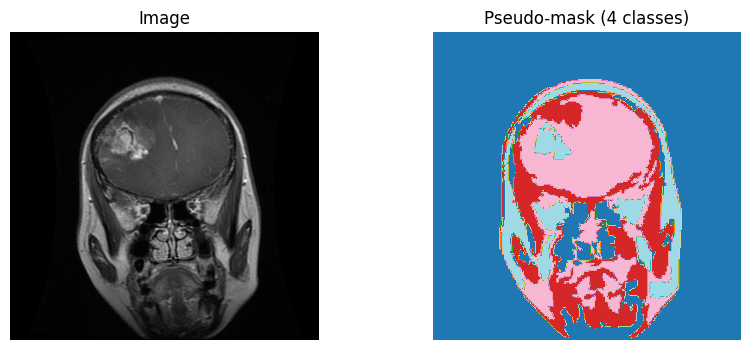

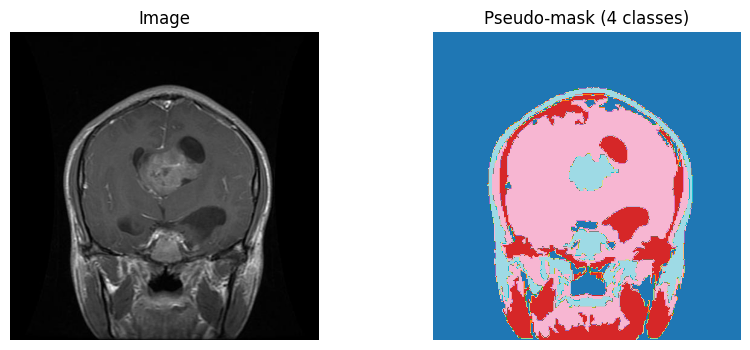

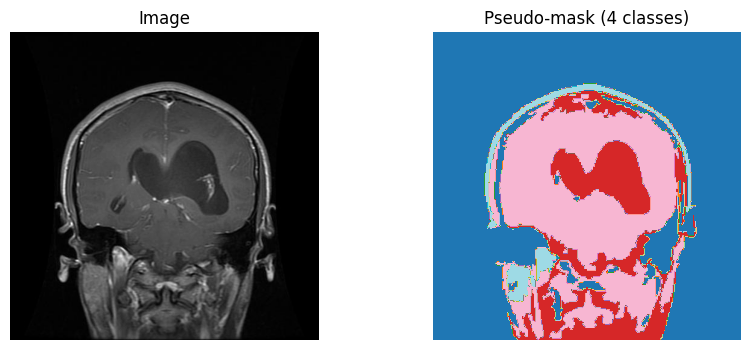

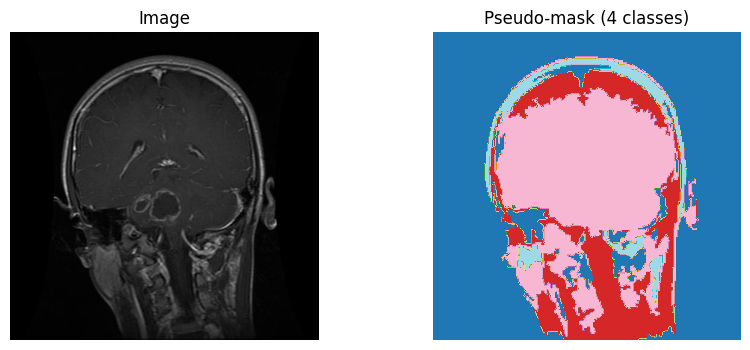

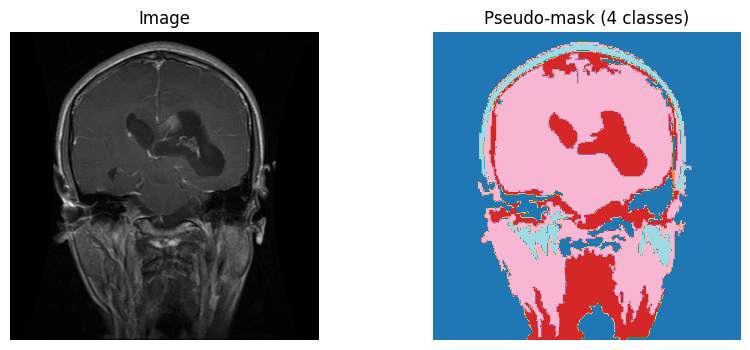

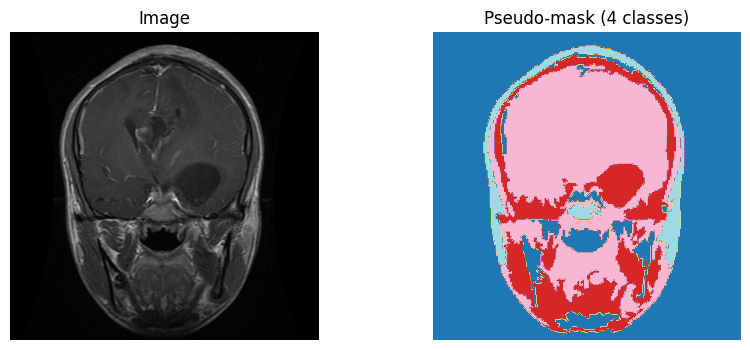

In [6]:
# Cell 5 / Visual check
def show_image_mask(img_p, mask_p, cmap='gray'):
    img = cv2.imread(str(img_p), cv2.IMREAD_GRAYSCALE)
    mask = cv2.imread(str(mask_p), cv2.IMREAD_UNCHANGED)
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1); plt.imshow(img, cmap='gray'); plt.title('Image'); plt.axis('off')
    plt.subplot(1,2,2); plt.imshow(mask, cmap='tab20'); plt.title('Pseudo-mask (4 classes)'); plt.axis('off')
    plt.show()

sample_imgs = sorted(IMAGES_DIR.glob('*'))[:6]
for s in sample_imgs[:6]:
    show_image_mask(s, MASKS_DIR / (s.stem + '.png'))


In [7]:
# Cell 6 / Split into train/val
all_images = sorted(IMAGES_DIR.glob('*'))
pairs = []
for p in all_images:
    m = MASKS_DIR / (p.stem + '.png')
    if m.exists():
        pairs.append((str(p), str(m)))
print("Total pairs:", len(pairs))

random.seed(42)
random.shuffle(pairs)
split_idx = int(0.8 * len(pairs))
train_pairs = pairs[:split_idx]
val_pairs = pairs[split_idx:]

print("Train:", len(train_pairs), "Val:", len(val_pairs))


Total pairs: 5712
Train: 4569 Val: 1143


In [8]:
# Cell 7 / PyTorch Dataset
class MRISegDataset(Dataset):
    def __init__(self, pairs, transforms=None):
        self.pairs = pairs
        self.transforms = transforms

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        img_p, mask_p = self.pairs[idx]
        img = cv2.imread(img_p, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_p, cv2.IMREAD_UNCHANGED)  # single channel with labels 0..K-1
        # ensure shapes
        if img is None or mask is None:
            raise RuntimeError(f'Bad pair: {img_p} {mask_p}')
        # Albumentations expects HWC
        img = cv2.resize(img, IMG_SIZE[::-1], interpolation=cv2.INTER_AREA)
        mask = cv2.resize(mask, IMG_SIZE[::-1], interpolation=cv2.INTER_NEAREST)
        img = img[..., None]
        if self.transforms:
            augmented = self.transforms(image=img, mask=mask)
            img = augmented['image']
            mask = augmented['mask']
        # image: tensor (C,H,W), mask: HxW array with class ids
        return img.float(), torch.from_numpy(mask).long()

# transforms
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=15, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.Normalize(mean=0.0, std=1.0),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Normalize(mean=0.0, std=1.0),
    ToTensorV2()
])

train_ds = MRISegDataset(train_pairs, transforms=train_transform)
val_ds = MRISegDataset(val_pairs, transforms=val_transform)

BATCH_SIZE = 8
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)


In [9]:
# Cell 8 / U-Net model (2D) - supports multi-class output
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )
    def forward(self, x): return self.net(x)

class UNet(nn.Module):
    def __init__(self, in_channels=1, out_classes=4, features=[64,128,256,512]):
        super().__init__()
        self.encs = nn.ModuleList()
        self.pools = nn.ModuleList()
        for f in features:
            self.encs.append(DoubleConv(in_channels, f))
            self.pools.append(nn.MaxPool2d(2))
            in_channels = f
        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        # decoder
        self.uptrans = nn.ModuleList()
        self.decs = nn.ModuleList()
        rev_features = features[::-1]
        for f in rev_features:
            self.uptrans.append(nn.ConvTranspose2d(f*2, f, kernel_size=2, stride=2))
            self.decs.append(DoubleConv(f*2, f))
        self.final = nn.Conv2d(features[0], out_classes, kernel_size=1)

    def forward(self, x):
        enc_feats = []
        for enc, pool in zip(self.encs, self.pools):
            x = enc(x)
            enc_feats.append(x)
            x = pool(x)
        x = self.bottleneck(x)
        for up, dec, enc_f in zip(self.uptrans, self.decs, reversed(enc_feats)):
            x = up(x)
            # ensure same size
            if x.size() != enc_f.size():
                x = TF.resize(x, size=enc_f.shape[2:])
            x = torch.cat([enc_f, x], dim=1)
            x = dec(x)
        logits = self.final(x)
        return logits

# instantiate
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(in_channels=1, out_classes=K).to(DEVICE)
print(model)


UNet(
  (encs): ModuleList(
    (0): DoubleConv(
      (net): Sequential(
        (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (1): DoubleConv(
      (net): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True

In [10]:
# Cell 9 / Loss and metrics
import torch.nn.functional as F

def dice_coeff(pred, target, smooth=1e-6):
    # pred: NxCxHxW probabilities (after softmax)
    # target: NxHxW (long labels)
    num_classes = pred.shape[1]
    dice = []
    for c in range(num_classes):
        p = pred[:,c,:,:].contiguous().view(-1)
        t = (target==c).float().contiguous().view(-1)
        inter = (p * t).sum()
        denom = p.sum() + t.sum()
        dice_c = (2. * inter + smooth) / (denom + smooth)
        dice.append(dice_c.item())
    return dice

criterion_ce = nn.CrossEntropyLoss()
# combined loss: CE + mean dice loss (1 - dice)
def combined_loss(logits, labels):
    ce = criterion_ce(logits, labels)
    probs = F.softmax(logits, dim=1)
    dice = dice_coeff(probs, labels)
    mean_dice = np.mean(dice)
    dice_loss = 1.0 - mean_dice
    return ce + dice_loss

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [11]:
# Cell 10 / Training loop
EPOCHS = 25
best_val_dice = 0.0
save_path = WORK_DIR / 'best_unet.pth'

for epoch in range(1, EPOCHS+1):
    model.train()
    train_loss = 0.0
    for imgs, masks in tqdm(train_loader, desc=f"Train E{epoch}"):
        imgs = imgs.to(DEVICE)  # shape B,C,H,W
        masks = masks.to(DEVICE)  # shape B,H,W (labels)
        logits = model(imgs)
        loss = combined_loss(logits, masks)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)

    # validation
    model.eval()
    val_loss = 0.0
    dices = []
    with torch.no_grad():
        for imgs, masks in tqdm(val_loader, desc=f"Val E{epoch}"):
            imgs = imgs.to(DEVICE)
            masks = masks.to(DEVICE)
            logits = model(imgs)
            loss = combined_loss(logits, masks)
            val_loss += loss.item()
            probs = F.softmax(logits, dim=1)
            batch_dice = dice_coeff(probs, masks)
            dices.append(batch_dice)
    val_loss /= len(val_loader)
    # average dice per class
    dices = np.array(dices)
    mean_dice_per_class = dices.mean(axis=0).tolist()
    mean_dice = np.mean(mean_dice_per_class)
    print(f"Epoch {epoch}: TrainLoss={train_loss:.4f} ValLoss={val_loss:.4f} ValDice={mean_dice:.4f} PerClassDice={mean_dice_per_class}")
    # save best
    if mean_dice > best_val_dice:
        best_val_dice = mean_dice
        torch.save({'model_state': model.state_dict(), 'epoch': epoch, 'dice': mean_dice}, str(save_path))
        print("Saved best model:", save_path)


Train E1:   0%|          | 0/572 [00:00<?, ?it/s]

TypeError: Caught TypeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/worker.py", line 349, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
           ^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/fetch.py", line 52, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/fetch.py", line 52, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
            ~~~~~~~~~~~~^^^^^
  File "/tmp/ipykernel_47/1200550539.py", line 26, in __getitem__
    return img.float(), torch.from_numpy(mask).long()
                        ^^^^^^^^^^^^^^^^^^^^^^
TypeError: expected np.ndarray (got Tensor)


In [ ]:
# Cell 11 / Inference and save visualizations
ckpt = torch.load(save_path, map_location=DEVICE)
model.load_state_dict(ckpt['model_state'])
model.eval()

OUT_PRED = WORK_DIR / 'predictions'
OUT_PRED.mkdir(parents=True, exist_ok=True)

def predict_and_save(img_path, out_vis_path, out_mask_path):
    img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
    h0, w0 = img.shape
    img_r = cv2.resize(img, IMG_SIZE[::-1], interpolation=cv2.INTER_AREA)
    inp = img_r[None,...,None].astype(np.float32)
    inp = np.transpose(inp, (0,3,1,2))  # N,C,H,W
    inp_t = torch.from_numpy(inp).to(DEVICE)
    with torch.no_grad():
        logits = model(inp_t)
        probs = F.softmax(logits, dim=1)[0].cpu().numpy()  # C,H,W
        pred = np.argmax(probs, axis=0).astype(np.uint8)
    pred_up = cv2.resize(pred, (w0, h0), interpolation=cv2.INTER_NEAREST)
    # save mask
    cv2.imwrite(str(out_mask_path), pred_up)
    # overlay: color map for classes
    cmap = np.array([[0,0,0],[255,0,0],[0,255,0],[0,0,255]], dtype=np.uint8)
    rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    overlay = rgb.copy()
    for c in range(K):
        overlay[pred_up==c] = cmap[c]
    vis = cv2.addWeighted(rgb, 0.6, overlay, 0.4, 0)
    cv2.imwrite(str(out_vis_path), vis)

# run on a few val images
for i,(img_p, mask_p) in enumerate(val_pairs[:20]):
    out_vis = OUT_PRED / (Path(img_p).stem + '_vis.png')
    out_mask = OUT_PRED / (Path(img_p).stem + '_pred.png')
    predict_and_save(img_p, out_vis, out_mask)
print("Saved predictions to", OUT_PRED)


In [ ]:
# Cell 12 / show some predictions inline
from IPython.display import Image, display

sample = list(OUT_PRED.glob('*_vis.png'))[:6]
for s in sample:
    display(Image(str(s)))
